<h1 style="color:red;">Time series</h1>

<h2 style="color:red;">Introduction</h2>

This notebook contains a summary of some important stochastic processes used to model time series: ARIMA, GARCH. It also contains some Python codes to plot/fit some real data.

Some useful references include:

* [ARIMA and GARCH Time Series by Marcel Blais (Youtube playlist)](https://youtube.com/playlist?list=PLf7Of__eXS8ILDGH3RDHZj932sa0TaJkS&si=fXFW_LuvWidmdQcV)

* Time Series Analysis by James D. Hamilton

<h2 style="color:red;">Definition</h2>
A stochastic process is a sequence of random variables. A time series is a sequence of observations over time (sampling from a stochastic process).

The aim when analysing a time series is to reconstruct the underlying stochastic process. This requires fitting a model defined by a set of parameters. Roughly speaking there are two possible scenarios:

* Overfitting: too many parameters have been used to model the data
* Underfitting: too few parameters have been used to model the data

<h2 style="color:red;">Stationarity</h2>

A stochastic process $\{X_t\}$ is called $\bold{stationary}$ (Strongly-stationary) if the joint distribution $\mathbb{P}[X_{t_1}, X_{t_2},...,X_{t_k}\}$ is time-independent for every collection $\{t_j\}_{j=1}^{k}$.

A stochastic process is called $\bold{weakly}$ $\bold{stationary}$ or $\bold{covariance}$ $\bold{stationary}$ if

* $\mathbb{E}[X_t] = \mu$ is time-independent
* $Var[X_t] = \sigma^2$ is time-independent 
* $Corr[X_tX_s] = f(|t-s|)$ depends only on the time difference.

Recall that 

$$ Corr[X_tX_s] = \frac{\mathbb{E}[X_t X_s]-\mathbb{E}[X_t]\mathbb{E}[X_s]}{\sqrt{Var[X_t]Var[X_s]}} $$

The autocorrelation function $Corr[X_tX_s]$ is denoted $\gamma_X(t,s)$; for a weakly stationary process we use $\gamma_X(t-s)$.

We define weak white noise as a stationary process satisfying 

* $\mathbb{E}[X_t] = \mu$
* $Var[X_t] = \sigma^2$
* $Corr[X_tX_s] = \begin{cases} 1 & t=s \\ 0  & t \neq s&\end{cases}$

If in addition $X_t \sim \mathcal{N}(0,\sigma^2)$, then $X_t$ is white noise denoted $w(t)$. The integral of standard white noise (i.e. with unit variance) is Brownian motion $W_t = \int_{0}^t ds w(s)$. 

We define the spectrum $s(\omega)$ of a weakly stationary (covariance stationary) time series $X_t$ as follows:

\begin{equation*}
s(\omega) = \frac{1}{2\pi} \sum_{s \in \mathbb{Z}}e^{i \omega s}Cov[X_{t+s},X_{t}] \equiv \frac{1}{2\pi} \sum_{s \in \mathbb{Z}}e^{i \omega s}\gamma(s)
\end{equation*}

Weak white noitse have a flat spectrum $s(\omega) = \sigma^2$ since $\gamma(s) = \delta_{s,0}$

<h2 style="color:red;">Parameter observation</h2>

If we have a single trajectory of the stochastic process $\{X_t\}$ we might need to estimate some parameters (mean, standard deviation etc..).

If the process is stationary and we have $N$ data points we can use the following estimators

1. $\mathbb{E}[X_t]$: Sample mean $\overline{X}_N = \frac{1}{N}\sum_{i=1}^{N}X_{t_i}$
2. $Var[X_t]$:  Sample variance $\overline{\sigma^2}_N = \frac{1}{N-1}\sum_{i=1}^{N}(X_{t_i}-\overline{X}_N )^2$
2. $Cov[X_{t+h}X_{t}] = \gamma(h)$: Sample covariance $\overline{\gamma(h)}_N = \frac{1}{N-h}\sum_{i=1}^{N-h}(X_{t_{i+h}}-\overline{X}_N)(X_{t_{i}}-\overline{X}_N)$

<h2 style="color:red;">Example: Generate a process with a given covariance matrix</h2>


We want to check how well these estimators perfom. We consider a stochastic process such that

* $\mathbb{E}[X_t] = 1$
* $Corr[X_{t+h}X_t] = \exp(-|h|)$

We can construct such a process starting from white noise $w_t$, then define a covariance matrix $\Sigma$. This is positive semidefinite hence define $X_t = L w_t$, where $LL^{\intercal} = \Sigma$ (Cholesky decomposition) where $L$ is a lower triangular matrix. Then we get the desired property

$$\Sigma = \mathbb{E}[XX^{\intercal}] = L\mathbb{E}(w w^{\intercal})L^{\intercal} = L L^{\intercal} $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

# Define the parameters
T = 1000  # Number of time steps
time_points = np.arange(1, T + 1)  # Time points: 1, 2, ..., T
mean_value = 1  # The desired mean value for the process

# Define the correlation function (Covariance matrix)
def correlation_function(t, s):

   return np.exp(-np.abs(t-s))

# Build the covariance matrix based on the correlation function
cov_matrix = np.zeros((T, T))
for i in range(T):
    for j in range(T):
        cov_matrix[i, j] = correlation_function(time_points[i], time_points[j])

# Cholesky decomposition of the covariance matrix
L = cholesky(cov_matrix, lower=True)

# Generate samples from a multivariate normal distribution
# This will give us a realization of the process with mean 0
white_noise = np.random.normal(size=T)
process_realization = L @ white_noise + mean_value  # Add the mean value to the process

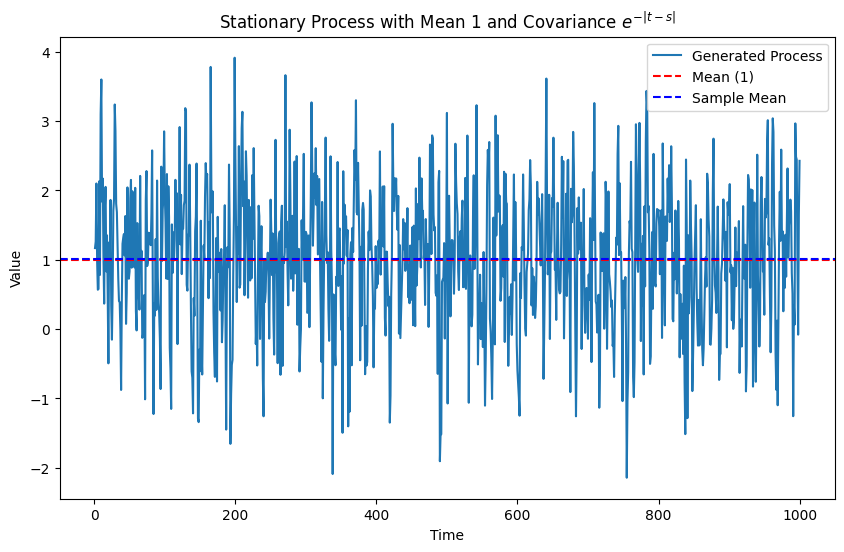

In [2]:
# Define Estimators

def sample_mean(process):
    return np.mean(process)

def corr(h, process):
    N = len(process)
    
    if h >= N:
        raise ValueError("Lag h must be less than the length of the process.")
    
    # Lagged process
    x = process[0:N-h]
    y = process[h:]
    
    # Compute correlation
    return np.corrcoef(x, y)[0, 1]

# Plot the generated process
plt.figure(figsize=(10, 6))
plt.plot(time_points, process_realization, label='Generated Process')
plt.axhline(mean_value, color='r', linestyle='--', label='Mean (1)')
plt.axhline(sample_mean(process_realization), color='b', linestyle='--', label='Sample Mean')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Stationary Process with Mean 1 and Covariance $e^{-|t - s|}$')
plt.legend()
plt.show()

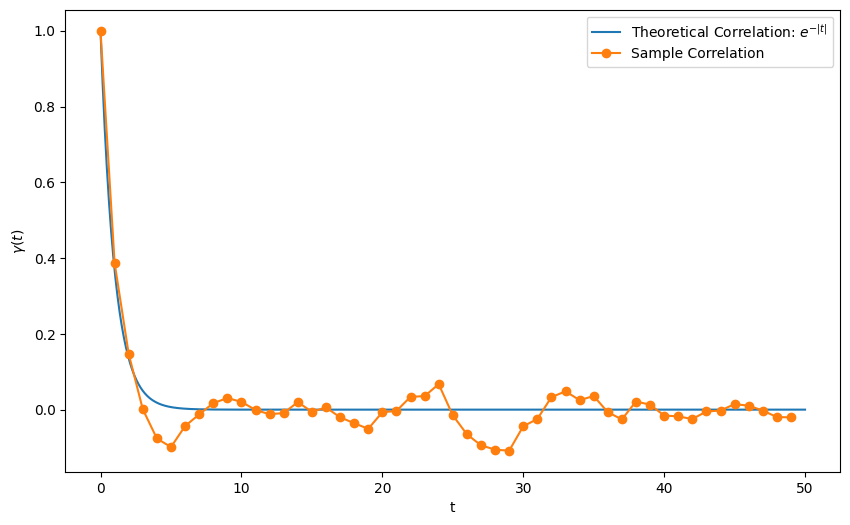

In [3]:
# Plot the correlation function

time_points_new = np.arange(0,50)
time_list = np.linspace(0,50,10**3)
plt.figure(figsize=(10, 6))
plt.plot(time_list, [np.exp(-abs(t)) for t in time_list], label='Theoretical Correlation: $e^{-|t|}$')
plt.plot(time_points_new, [corr(t,process_realization) for t in time_points_new], label='Sample Correlation',marker="o")
#plt.yscale("log")
plt.xlabel('t')
plt.ylabel('$\gamma(t)$')
plt.legend()
plt.show()

<h2 style="color:red;">AR(1)</h2>


This is an autoregressive process $\{X_t\}$ described by:

$$X_t-\mu = \phi(X_{t-1}-\mu) + \epsilon_t$$

where $\epsilon_t$ is white noise (i.e. a Gaussian random variable).

Iterating yields

$$X_t -\phi^{t}X_0=\mu(1-\phi)\sum_{j=1}^{t}\phi^{t-j}(1+\epsilon_j)$$

If we assume $|\phi|<1$, we can take the lower limit to be $-\infty$ and get

$$X_t = \mu + \sum_{j=-\infty}^{t}\phi^{t-j}\epsilon_j = \mu + \sum_{h=0}^{\infty}\phi^{h}\epsilon_{t-h}$$

* $\mathbb{E}[X_t] = \mu$
* $Cov[X_t,X_{t+h}] = \sum_{j\geq 0}\sum_{j'\geq 0}\phi^{j+j'}Cov[\epsilon_{t-j},\epsilon_{t+h-j'}]  = \frac{\sigma^2\phi^{|h|}}{1-\phi^2} $
where we used the fact that $Cov[\epsilon_j,\epsilon_k] = \sigma^2\delta_{jk}$

How to estimate the parameters $\mu,\phi$?

We can use minimise the sum of the squared residuals. Notice that a AR(1) model is linear:

$$Y_t = \mu(1-\phi) + \phi Y_{t-1} + \epsilon_t \equiv \beta_0 + \beta_1 Y_{t-1} + \epsilon_t $$

Let $\beta^{\intercal} = [\beta_0, \beta_1]$, and assume we have $t$ data points $Y^{\intercal} = [X_0, X_1,...,X_{t-1}]$, then we have a $t \times 2$ design matrix given by

$$X = \begin{bmatrix}
1 & 0 \\
1 & X_0 \\
1 & X_1 \\
\vdots & \vdots \\
1 & X_{t-2}
\end{bmatrix}
$$

Hence, we can write $Y = X \beta$, we then minimise $f(\beta) = (Y-\hat{Y})^{\intercal}(Y-\hat{Y}) = (Y-X \beta)^{\intercal}(Y-X \beta) = (Y-X \beta) \cdot (Y-X \beta)$ with respect to $\beta$, meaning that we enforce the gradient $\nabla_\beta f(\beta)$ to be zero.

\begin{align*}
\nabla_\beta f(\beta) &= \nabla_\beta \left( (Y- X\beta) \cdot (Y-X\beta)\right) = \nabla_\beta \left( -Y \cdot (X \beta) - (X \beta)\cdot Y+ X \beta \cdot X \beta \right) = \nabla_\beta \left((-2X^{\intercal}Y+ X^{\intercal}X \beta)\cdot\beta  \right)\\ 
&= -2(X^{\intercal}Y+X^{\intercal}X \beta)  = 0
\end{align*}

Hence, our estimate for $\phi, \mu$ is

$$
\beta = (X^{\intercal}X)^{-1}X^{\intercal}Y
$$

Note also that if our estimate $\hat{Y}_{t}$ is close to the actual process $Y_t$, then we should have $\hat{Y}_t-Y_t \equiv  \hat{\epsilon}_t$ where $\hat{\epsilon}_t$ should look like $\epsilon_t$ (i.e. the residuals should look like weak white noise).


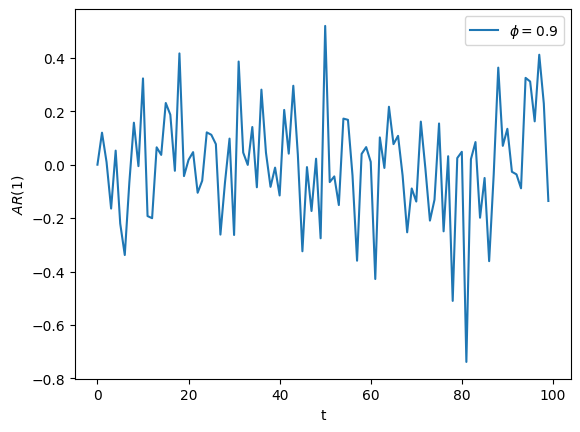

In [4]:
def AR1(sigma,mu,phi,t):
    if t==0:
        return 0
    else:
        return mu + phi*(AR1(sigma,mu,phi,t-1)-mu) + np.random.normal(0,scale=sigma)   

t_list = np.arange(0,100)

phi = 0.9
sigma = 0.1
mu = 0

plt.plot(t_list, [AR1(sigma,mu,phi,t) for t in t_list], label = "$\phi = $"+str(phi))
plt.xlabel('t')
plt.ylabel('$AR(1)$')
plt.legend()
plt.show()

<h2 style="color:red;">ARIMA(p,d,q)</h2>
This is a Autoregressive Integrated Moving Average process. It is formed by combining three processes

* AR(p) (autoregressive process): $X_t = \sum_{h=1}^{p}\phi_{h}X_{t-h} + \epsilon_t$
* I(d) (integrated process): $X'_t = \Delta^{d}_{t}X_t$ (i.e. we apply the backward difference operator $\Delta_tf_t = f_{t}-f_{t-1}$ $d$ times)
* MA(q) (moving average): $X_t = \sum_{h=1}^{p}\theta_{h}\epsilon_{t-h} + \epsilon_t$

Each component is used as follows:

* AR(p): if the data shows significant autocorrelation (i.e. future data depends strongly on past data)
* I(d): if the data is not stationary apply differencing till the data looks stationary.
* MA(q): if there are correlations in the residuals it may indicate the need for an MA(q) component. MA models capture short-term shocks or random noise in the series that might be missed by the AR part. 

Notice that an AR(1) process can be thought as a $MA(\infty)$ process and a $MA(1)$ as an $AR(\infty)$ process.

We now briefly describe each process separately.

<h3 style="color:red;">AR(p)</h3>

AR(p) model can be re-written as $\Phi(B)X_{t} = \epsilon_t$, where $BX_t= X_{t-1}$ and $\Phi(z) =  1-\sum_{h=1}^{p}\phi_{h}z^{h}$ is a polynomial. Note that at the moment $\mathbb{E}[X_t]=0$, if we want to introduce $\mathbb{E}[X_t]= \mu$, we need to replace, for all $t$, $X_{t} \to X_{t}-\mu$

AR(p) is stationary only if the roots of $\Phi(z)$, $\{z_j\}_{j=1}^{h}$, lie all outside the unit-circle $|z_j|>1$ $\forall j$. This is true beacause we can write a AR(p) as a $MA(\infty)$ process:

$$
\Phi(B)X_{t} = \epsilon_t \implies X_t = \frac{\epsilon_t}{\Phi(B)}
$$

We can then expand $\Phi(B)^{-1} as a power series in $B$:

$$
\frac{1}{1-\sum_{h=1}^{p}\phi_{h}B^{h}} = \sum_{j=1}^{p} \frac{C_j(B)}{B_j-B} = \sum_{j=1}^{p} (C_j(B)/B_j) \sum_{n \geq 0}(B/B_j)^n
$$

where in the first equality we have used the partial fraction decomposition, where $C_j(B)$ might contain some $B$ dependence (if the polynomial is irreducible over $\mathbb{R}$). Then, we have an expression of the form, for some $c_n$,: 

$$
X_t = \sum_{n \geq 0}c_n\epsilon_{t-n}
$$

wich converges providded that $|1/B_j|<1 \implies |B_j|>1$.


The parameters $\phi_j$ can be estimated minimising the square of residuals (similar to the AR(1) model). The generic autocorrelation function can be found by multiplying $X_t$ by $X_{t-h}$:

$$
X_t X_{t-h} =  \sum_{j=1}^{p}\phi_jX_{t-j}X_{t-h} + \epsilon_t X_{t-h}
$$

Taking $\mathbb{E}[\cdot]$ on both sides yields the Yule-Walker equations:

$$
\gamma_{h} = \sum_{j=1}^{p}\phi_j\gamma(h-j) \implies \Phi(B)\gamma(h) = 0
$$


<h3 style="color:red;">I(d)</h3>

This is a model defined by

$$
\Delta^d_tX_t = (1-B)^dX_t = \epsilon_t
$$

when $d=1$ it reduces to a random walk. Note that $I(1)$ is not stationary as

$$
X_t = \mu + X_{t-1} + \epsilon_t \implies X_t = X_0 + \mu t + \sum_{n=1}^{t}\epsilon_t
$$

Hence, $E[X_t] = E[X_0] + \mu t$ and $Var[X_t] = \sigma^2 t + Var[X_0]$. The autocovariance is

$$
Cov[X_t,X_{t+|h|}] = V[X_0] + \sigma^2\sum_{n=1}^{t}1 = V[X_0] + \sigma^2 t
$$

We can see that $I(1)$ is similar to a $AR(1)$ process with a unit root, since the characteristic polynomial of $X_t-X_{t-1}$ is $1-z$. Hence, $I(d)$ is a process with $d$ unit roots.

In general, we apply differencing, $X_t \to \Delta^d_tX_t$, until the process $X_t$ looks stationary. When a series is not stationary we usually see some sudden upward/downward trends and period of small fluctuations followed by large fluctuations or viceversa.


<h3 style="color:red;">MA(q)</h3>

This is a moving average process of order $q$

$$
X_t = \sum_{h=1}^{p}\theta_{h}\epsilon_{t-h} + \epsilon_t = \Theta(B)\epsilon_t
$$

where 

$$
\Theta(z) = 1+\sum_{h=1}^{p}\theta_{h}z^h
$$

This process is weakly stationary since the sum contains a finite amout of terms.

<h3 style="color:red;">ARMA(p,q)</h3>

We con combine the AR(p) and MA(q) process to get


$$
X_t = \sum_{h=1}^{p}\phi_{h}X_{t-h}+\sum_{h=1}^{q}\theta_{h}\epsilon_{t-h} + \epsilon_t 
$$

which can be written compactly as

$$
X_t = \frac{\Theta(B)}{\Phi(B)}\epsilon_t
$$

Note that we require the polynomial $\Theta(B)$ and $\Phi(B)$ to have no common factors, so that a process is indeed $ARMA(p,q)$. As an example consider white noise $Y_t = \epsilon_t$, we could in principle multiply both sides by the polynomial $(1-B)$ to obtain $Y_{t}-Y_{t-1} = \epsilon_{t}-\epsilon_{t-1}$, we will not classify this as a ARMA(1,1) process as it is reducible.

<h2 style="color:red;">How to choose the parameters p, d, and q?</h2>

<h3 style="color:red;"> 1) d</h3>

The parameter $d$ is nonzero if the process is not stationary. If we introduce $I(d)$ component, then we introduce $d$ unit roots; hence, we need a test to check for unit roots. One such a test is the Augmented Dickey-Fuller (ADF) Test. 

<h3 style="color:red;"> ADF test d</h3>

It is a test with a null hypothesis:

* $H_0$: There is a unit root

Hence if the $p$-value is small we should reject the null-hypothesis and conclude that the series might be stationary. If we cannot reject the null hypothesis, we  can try to difference the data until the $p$ value is small enough so that we can reject it.

The ADF test is based on fitting the following model

$$
\Delta X_t = \alpha + \beta X_{t-1}+\sum_{i=1}^{p}\gamma_i\Delta X_{t-i} + \epsilon_t
$$

we then determine by OLS (ordinary least square) the parameters $\alpha,\beta,\gamma_i$. If $\beta$ is zero there is a unit root. We can then run a t-test

$$
t = \frac{\hat{\beta}_n}{\hat{\sigma}_n/\sqrt{n}}
$$

where $\hat{\beta}_n$ is the estimated value of $\beta$ from OLS having $n$ data points and $\hat{\sigma}_n/\sqrt{n}$ is the standard error on $\beta$. In general, a closed formula for the distribution of the $t$ statistic, for each degree of fredom $n$, is not available. However, we can numerically simulate the process and tabulate the $q$-th percentile of the distribution. In some cases, we can compute the asymptotic distribution as $n \to \infty$. Consider the case of a $Id(1)$ process, with $T$ data points

$$
y_t = y_{t-1} + \epsilon_t
$$

Then the design matrix is a $T \times 1$ matrix given by $X = BY$, where $B$ is the backward shift operator $B e_{j} = e_{j-1}$. Hence,

$$
\hat{\phi}_T = (X^{\intercal}X)^{-1}X^{\intercal}Y = (Y^{\intercal}Y)^{-1}(Y^{\intercal}BY) = \frac{\sum_{t=1}^{T}y_ty_{t-1}}{\sum_{t=1}^{T}y^2_{t-1}}
$$

What is the limit distribution of $\hat{\phi}_T$ as $T \to \infty$?

<h3 style="color:red;"> Generic distribution of estimated $\hat{\beta}_T$ in a regression model</h3>

We solve a more generic problem regarding the distribution of the OLS estimate of $\beta$. Consider a linear model

$$
Y = X \beta + \epsilon
$$

where $X$ is a design matrix with $k$ independent parmeters and $T$ observations (hence it is a $T \times k$ matrix), $\beta$ is a $k \times 1$ column of independent parameters and $\epsilon$ a $T \times 1$ vectors of uncorrelated white noise. The design matrix can be written as

$$
X = 
\begin{bmatrix}
X_1^{\intercal} \\
X_2^{\intercal}\\
\vdots \\
X_T^{\intercal}
\end{bmatrix}
$$

where $X_i$ is a $k \times 1$ column vector. We then have that the OLS estimate for $\beta$ is

$$
\hat{\beta}_T = (X^{\intercal}X)^{-1}X^{\intercal}Y \implies \hat{\beta}_T-\beta = (X^{\intercal}X)^{-1}X^{\intercal}\epsilon = ({T^{-1}\sum_{t=1}^T X_t X^{\intercal}_t})^{-1}(T^{-1}\sum_{t=1}^T \epsilon_t X_t)
$$

The term $T^{-1}X^{\intercal}X$ tends to the covariance matrix $Q$; hence the first term tends to $Q^{-1}$, whereas the second term has zero mean and variance $T^{-2}Var[X^{\intercal}\epsilon] = T^{-2}\sigma^2X^{\intercal}X \to \sigma^2Q/T$; hence

$$
\hat{\beta}_T-\beta \sim \mathcal{N}(0, Q^{-1}(\sigma^2 Q/T)(Q^{-1})^{\intercal}) = \mathcal{N}(0, \sigma^2Q^{-1}/T) \implies \sqrt{T}(\hat{\beta}_T-\beta) \sim \mathcal{N}(0,\sigma^2Q^{-1})
$$

We can now specialise to the AR(1) process for which $Q = \sigma^2/(1-\phi^2)$:

$$
\sqrt{T}(\hat{\beta}_T-\beta) \sim \mathcal{N}(0,1-\phi^2)
$$

It is now clear that when $\phi \to 1$ the variance is zero, which suggest that we need a different scaling instead of $\sqrt{T}$.
In this limit the $AR(1)$ process becomes non-stationary and effectively a $I(1)$ process:

$$
Y_t = \sum_{t'=1}^t\epsilon_{t'}
$$

It is useful to invoke the functional central limit theorem which states that

$$
\frac{1}{\sqrt{T}}\sum_{t=1}^{\lfloor T r\rfloor}\epsilon_t \to \sigma W(r)
$$

where $r \in [0,1]$, $\epsilon_t$ is a weak white noise, and $W(r)$ is Brownian motion. We can then re-write the denominator (after scaling it by $T^{-2}$ instead of $T^{-1}$) of the OLS as

$$
T^{-2}\sum_{t=1}^{T}Y^2_t \to \sigma^2\int_{0}^1 dr (W(r))^2
$$

since $1/T\sum_{t=1}^{T} \to \int_{0}^{1}dr$ and $Y^2_t/T \to \sigma^2(W(r))^2$. 

Similarly the denominator can be manipulated

$$
\sum_{t=1}^TY_{t-1}\epsilon_t = \frac{1}{2}\left[Y^2_t-Y^2_0 +\sum_{t=1}^{T}\epsilon^2_t\right] = \frac{1}{2}\left[Y^2_t+\sum_{t=1}^{T}\epsilon^2_t\right]
$$

Hence we obtain, after divinding by $T$,

$$
T^{-1}\sum_{t=1}^TY_{t-1}\epsilon_t \to \frac{1}{2}(\sigma^2(W(1))^2-\sigma^2)
$$

we then conclude that


$$
T(\hat{\beta}_T-\beta) = \frac{T^{-1}\sum_{t=1}^TY_{t-1}\epsilon_t }{T^{-2}\sum_{t=1}^{T}Y^2_t} \to \frac{\frac{1}{2}((W(1))^2-1)}{\int_{0}^1 dr (W(r))^2}
$$

$W(1)$ is a Gaussian variable $\mathcal{N}(0,1)$; hence, $(W(1))^2$ is a $\chi^2_1$ variable. The random variable $\int_{0}^1 dr (W(r))^2$ does not have a standard distribution.


<h3 style="color:red;"> 2) q</h3>

The parameter $q$ in the MA(q) process is determined considering the autocorrelation function (ACF). This function $\gamma(h)/\gamma(0)$ is nonzero for $|h| \leq q$ and zero otherwise:

\begin{align*}
Cov[X_t, X_{t+|h|}] &= \sum_{j=0}^{q}\sum_{j'=0}^{q}Cov[\epsilon_{t-j'},\epsilon_{t+|h|-j}] = \sigma^2\sum_{j=0}^{q}\sum_{j'=0}^{q}\theta_{j}\theta_{j'}\delta_{j',j-|h|} \\
& = \sigma^2\sum_{j=0}^{q}\theta_{j}\theta_{j-|h|}I[|h|\leq j\leq |h| +q ] = I[|h|\leq q]\sigma^2\sum_{j=|h|}^{q}\theta_{j}\theta_{j-|h|}
\end{align*}

Hence, in order to estimate the value of $q$, it suffices to plot the sample ACF function and check after how many lags it cuts off (i.e.becomes zero).


<h3 style="color:red;"> 3) p</h3>
Since $AR(p)$ can be tought as a $MA(\infty)$ process, the ACF of a $AR(p)$ process never become zero (but it decays exponentially).
The parameter $p$ is estimated by considering a partial autocorrelation function (PACF) function. This is a conditional correlation function:

$$
\phi_h = Corr[X_{t},X_{t+h}|\{X_{t+1},X_{t+2},...,X_{t+h-1}\}]
$$

<h3 style="color:red;"> ACF and PACF of AR(p) and MA(q)</h3>

Below is a Python script which calculate the sample ACF and PACF for a AR(p) and MA(q) process

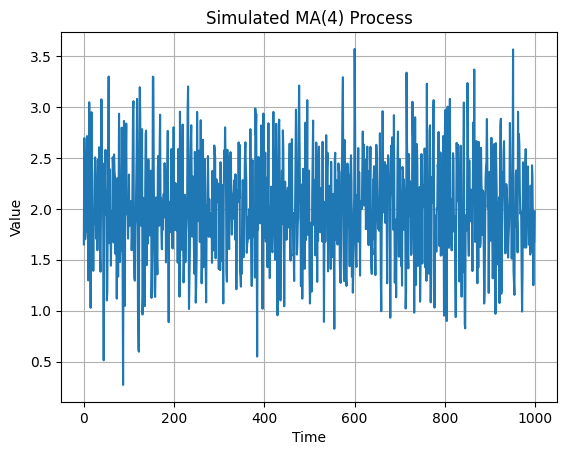

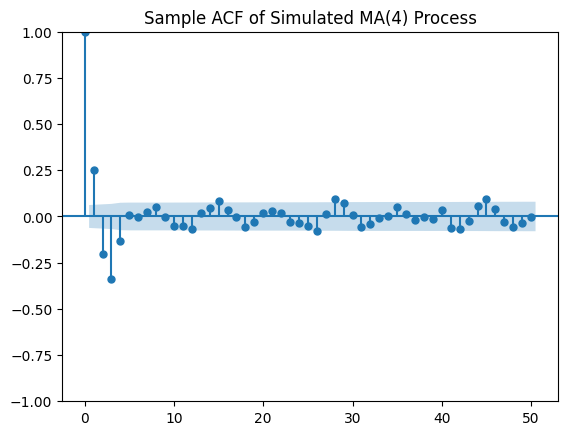

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

# ARIMA(3, 0, 0) parameters
p, d, q = 0, 0, 4  # MA(4)

# AR coefficients (mu, theta1, theta2, theta3, theta4, sigma^2)
params = [2, 0.2, -0.2, -0.4,-0.2, 0.2]



# Simulate the process
n = 1000  # Number of simulated points

# Initialize ARIMA model with dummy data
arima_model = ARIMA(np.zeros(n), order=(p, d, q))

path = arima_model.simulate(params=params, nsimulations=n)

# Plot the simulated AR process
plt.plot(path)
plt.title(f"Simulated MA({q}) Process")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()

# Plot the ACF
plot_acf(path, lags=50)
plt.title(f"Sample ACF of Simulated MA({q}) Process")
plt.show()


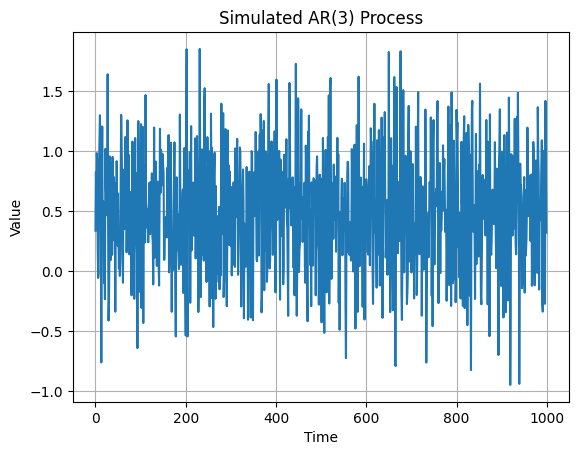

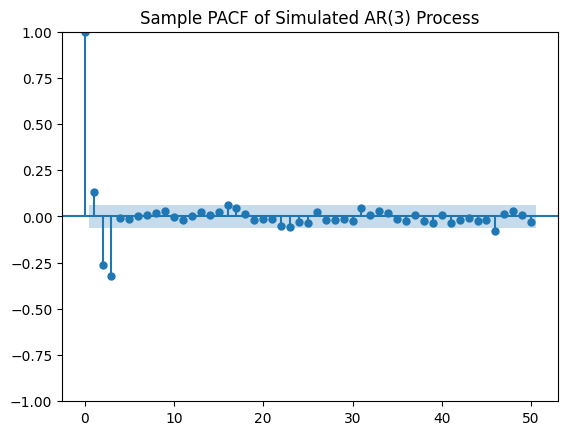

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

# ARIMA(3, 0, 0) parameters
p, d, q = 3, 0, 0  # AR(3)

# AR coefficients (mu, phi1, phi2, phi3, sigma^2)
params = [0.5, 0.1, -0.2, -0.3, 0.2]



# Simulate the process
n = 1000  # Number of simulated points

# Initialize ARIMA model with dummy data
arima_model = ARIMA(np.zeros(n), order=(p, d, q))

path = arima_model.simulate(params=params, nsimulations=n)

# Plot the simulated AR process
plt.plot(path)
plt.title(f"Simulated AR({p}) Process")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()

# Plot the PACF
plot_pacf(path, lags=50)
plt.title(f"Sample PACF of Simulated AR({p}) Process")
plt.show()


<h2 style="color:red;"> Fitting of ARIMA</h2>

Fitting the parameters of the $AR(p)$ component can be done using OLS since a $AR(p)$ model is a linear model. 

ARIMA can be used to fit some data like

* Financial Data:
Stock prices, exchange rates, and other financial time series.
* Economic Data:
GDP, inflation rates, unemployment rates.
* Sales Data:
Monthly, weekly, or daily sales volumes.

Below we used panda to fit a ARIMA(1,1,1) model to the US GDP.

ADF Statistic: -7.324980355602133
p-value: 1.1674222108701685e-10
Critical Values: {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}


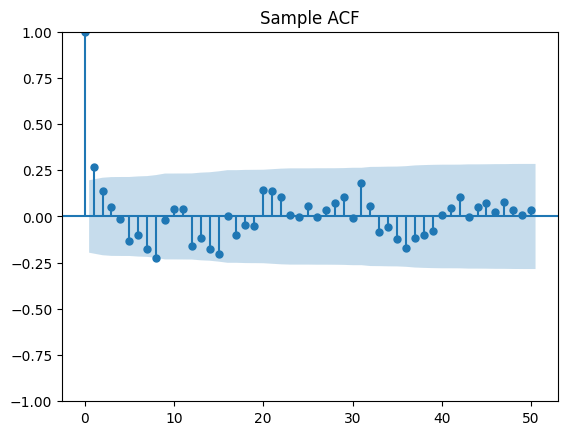

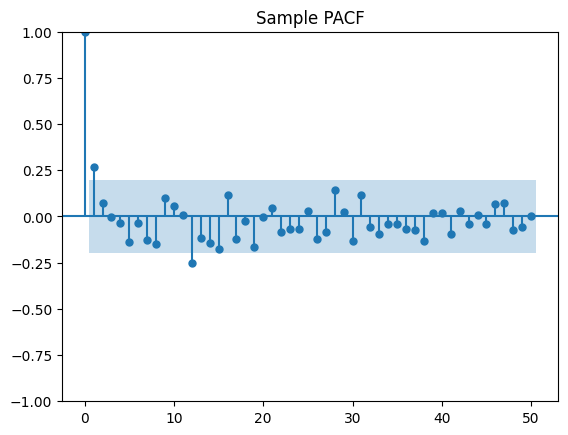

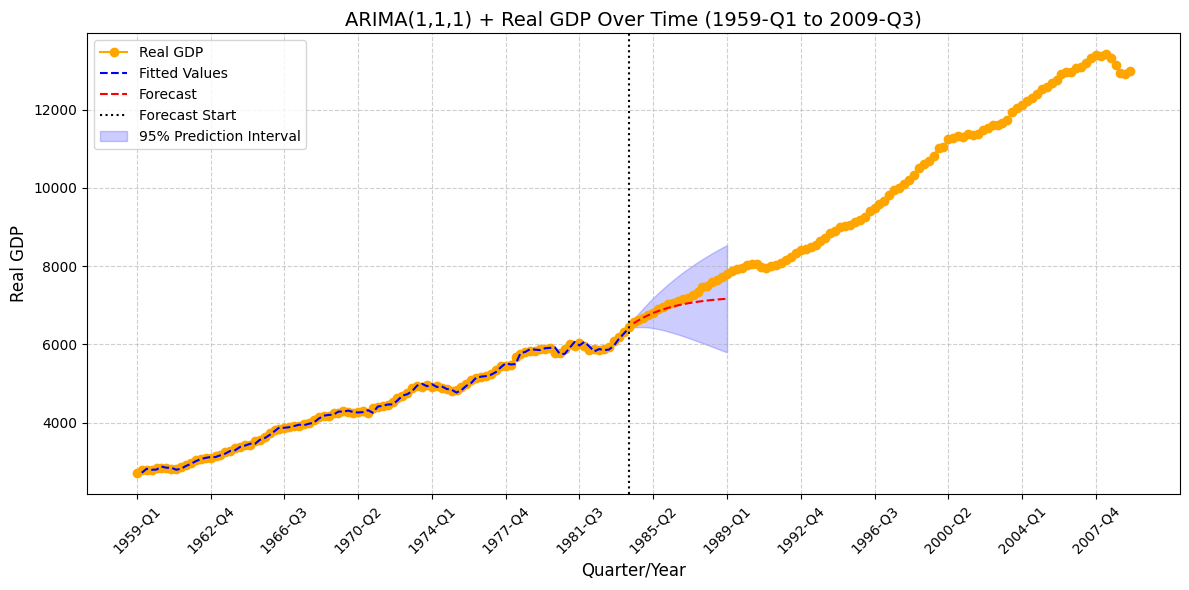

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

data = sm.datasets.macrodata.load_pandas().data
L = len(data['realgdp'])
gdp = data['realgdp'][:-L//2]
gdp_full = data['realgdp']

# Run the Augmented Dickey-Fuller test
adf_result = adfuller(gdp.diff().dropna())

# Extract and print the results
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

# Plot ACF/PACF of first order differencing
plot_acf(gdp.diff().dropna(), lags=50)
plt.title(f"Sample ACF")
plt.show()

plot_pacf(gdp.diff().dropna(), lags=50)
plt.title(f"Sample PACF")
plt.show()

# Fit ARIMA(p=1, d=1, q=1) model
model = ARIMA(gdp, order=(1, 1, 1))
result = model.fit()

# Forecasting next 20 periods
forecast_steps = 20
forecast = result.get_forecast(forecast_steps)
forecast_values = forecast.predicted_mean  # Mean predictions
conf_int = forecast.conf_int(alpha=0.05)  # 95% confidence intervals
forecast_index = range(len(gdp), len(gdp) + forecast_steps)

# Plot the full fit + forecast
# Load the dataset
data = sm.datasets.macrodata.load_pandas().data

# Create a new column for the combined quarter and year
data['time'] = data['year'].astype(int).astype(str) + "-Q" + data['quarter'].astype(int).astype(str)



# Plot the real GDP data against the combined quarter/year
plt.figure(figsize=(12, 6))
plt.plot(data['time'], data['realgdp'], marker='o', label="Real GDP", color = 'orange')
plt.xticks(range(0, len(data['time']), 15), data['time'][::15], rotation=45)  # Show every 15th label for clarity
plt.title("ARIMA(1,1,1) + Real GDP Over Time (1959-Q1 to 2009-Q3)", fontsize=14)
plt.xlabel("Quarter/Year", fontsize=12)
plt.ylabel("Real GDP", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.plot(result.fittedvalues[1:], label='Fitted Values', color='blue', linestyle='--')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red', linestyle='--')
plt.axvline(len(gdp) - 1, color='black', linestyle=':', label='Forecast Start')
conf_int = forecast.conf_int(alpha=0.05)  # 95% confidence interval
plt.fill_between(forecast_index, 
                 conf_int.iloc[:, 0], conf_int.iloc[:, 1], 
                 color='blue', alpha=0.2, label='95% Prediction Interval')
plt.legend()
plt.tight_layout()
plt.show()


<h2 style="color:red;">SARIMA</h2>

An extension of $ARIMA(p,q)$ is SARIMA (seasonal ARIMA) indicated $ARIMA(p,d,q)(P,D,Q)_s$. This is a process described by:

$\Phi_{p}(B)\tilde{\Phi}_P(B^s)(1-B)^d(1-B^s)^DX_t = \Theta_{q}(B)\tilde{\Theta}_Q(B^s)\epsilon_t$.

$\Phi_{p}(z) = \sum_{i=1}^{p}\phi_i z^{i}$, $\Phi_{P}(B) = \sum_{i=1}^{P}\tilde{\phi}_iz^{i}$, $\Theta_{q}(z) = \sum_{i=1}^{q}\theta_i z^{i}$ and $\tilde{\Theta}_{Q}(z) = \sum_{i=1}^{P}\tilde{\theta}_iz^{i}$ are polynomials and $s$ indicates the seasonal parameter.

A process $ARIMA(0,0,0)(0,0,Q)_s$ will show a spike at lag $s$, $2s$... $Qs$ in the ACF, whereas $ARIMA(0,0,0)(P,0,0)_s$ has spikes in the PACF at lag $s$,..$Ps$.

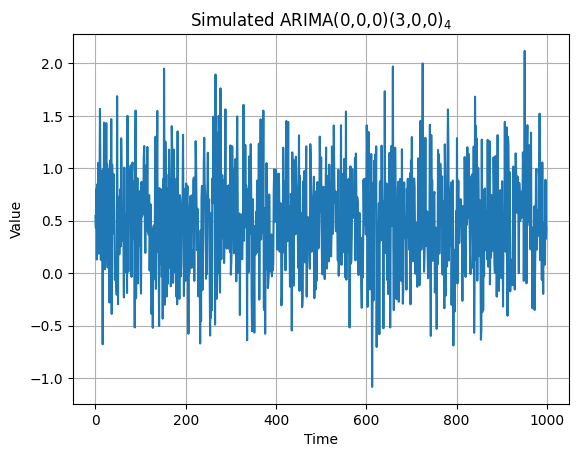

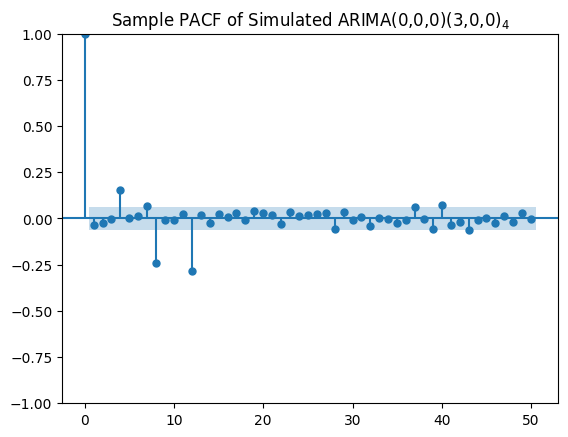

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

# SARIMA(0,0,0)(3, 0, 0)_4 parameters
p, d, q = 0, 0, 0

P, D, Q, s= 3,0,0,4


# AR coefficients (mu, tilde_phi1, tilde_phi2, tilde_phi3, sigma^2)
params = [0.5, 0.1, -0.2, -0.3, 0.2]



# Simulate the process
n = 1000  # Number of simulated points

# Initialize SARIMA model with dummy data
arima_model = ARIMA(np.zeros(n), order=(p, d, q), seasonal_order=(P,D,Q,s))

path = arima_model.simulate(params=params, nsimulations=n)

# Plot the simulated SARIMA process
plt.plot(path)
plt.title(f"Simulated ARIMA({p},{d},{q})({P},{D},{Q})$_{s}$")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()

# Plot the PACF
plot_pacf(path, lags=50)
plt.title(f"Sample PACF of Simulated ARIMA({p},{d},{q})({P},{D},{Q})$_{s}$")
plt.show()


<h2 style="color:red;">Maximum likelihood estimation</h2>

Previously, we have briefly discussed how to estimate the parameters $\mu,\phi$ of an AR(1) process using OLS (ordinary least squares). The same logic can be extended to an AR(p) process. This works because AR(p) models are linear in the observation data $Y_t$. How can we estimate the parameters $\theta_i$ in a MA(q) process, given that the lags $\epsilon_{t-j}$ are not observables?

The short answer it to use the maximum likelihood estimation. Consider a stochastic process $X_t$ parameterised by a list of variables which we gather in a vector $\theta$. Consider a trajectory consisting of $T$ data points ${X_1,...,X_T}$, how can we estimate $\theta$? We can consider the joint distribution $f_{X_1,..,X_T}(x;\theta)$ which is parameterised by the vector $\theta$  and $x = (x_1,...,x_n)$ are the variables. We can view this distribution as a function of $\theta$ for fixed $x_1,..x_T$ (observed data points), this is the likelyhood function. We can then ask what are the optimal $\theta$ such that the observation made is the most likely. Hence, we maximise $f_{X_1,..,X_T}(x;\theta)$ with respect to $\theta$ for fixed $x$; this will give us an estimate for $\theta$. To make progress we need to make assumptions regarding the fucntion $f$, which in principle cannot be determined. Usually, we assume that the error terms in our model is Gaussian white noise.

<h3 style="color:red;">Conditional likelihood</h3>

We first start with a MA(1) process:

\begin{equation}
Y_{t+1} = \mu + \epsilon_{t+1} + \theta\epsilon_{t}
\end{equation}

We first derive the conditional likelihood on the fact that $\epsilon_0 = 0$.



Let $\boldsymbol{\theta} = (\mu,\theta,\sigma^2)$ be the vector that we want to estimate; to do so we assume that $\epsilon_{t} \sim \mathcal{N}(0,\sigma^2)$ is white noise. It follows that $Y_{t+1}$ conditioned on $\epsilon_{t}$ is distributed as a Gaussian variable
\begin{equation*}
Y_{t+1}|\epsilon_{t} \sim \mathcal{N}(\mu+\theta\epsilon_{t}, \sigma^2)
\end{equation*}

because conditioning over $\epsilon_{t}$ means that it is treated as a constant. If we then observe $Y_{t+1}$ we then known the value of $\epsilon_{t+1}$ with certainity since $\epsilon_{t+1} = Y_{t+1}-\mu-\theta \epsilon_{t}$. Hence, we know the conditional distribution of $Y_{t+2}$:

$$
Y_{t+2}|Y_{t+1},\epsilon_{t} \sim \mathcal{N}(\mu+\theta\epsilon_{t+1}(Y_{t+1},\epsilon_t), \sigma^2)
$$

where the notation $\epsilon_{t+1}(Y_{t+1},\epsilon_t)$ emphasises that $\epsilon_{t+1}$ is a function of $Y_{t+1}$ and $\epsilon_{t}$. 
Usually we start with $\epsilon_0=0$ we can then iterate this procedure to find:

$$
f_{Y_t|Y_{t-1},...,Y_1,\epsilon_0=0}(y_t|y_{t-1},...,y_1,\epsilon_0) = \frac{1}{\sqrt{2\pi}}e^{-\frac{(y_{t}-\mu-\theta\epsilon_{t-1})^2} {2\sigma^2}} = \frac{1}{\sqrt{2\pi}}e^{-\frac{\epsilon_t^2}{2\sigma^2}}
$$

where $\epsilon_t  = y_{t}-\mu-\theta \epsilon_{t-1}$ should be interepted as a function of the observations variables $Y_{t-1}=y_{t-1},...,Y_1 = y_1$ by iterating the recurrence backwards.

We can then find the distribution of the $Y_t,...,Y_1$ conditioned on $\epsilon_0=0$ multiplying them:

$$
f_{Y_T,Y_{T-1},...,Y_1|\epsilon_0=0}(y_T,y_{T-1},...,y_1|\epsilon_0) = \prod_{t=1}^{T}\frac{1}{\sqrt{2\pi \sigma^2}}e^{-\frac{\epsilon_t^2}{2\sigma^2}}
$$

we can then find the log-likelihood:

$$
\mathcal{L}(\boldsymbol{\theta}) = \sum_{t=1}^{T} \Bigl[-\log(\sqrt{2\pi}) -\log(\sigma)-\frac{\epsilon_t^2}{2\sigma^2}\Bigr] = -T(\log(\sqrt{2\pi}) -\log(\sigma)) - \sum_{t=1}^{T}\frac{\epsilon_t^2}{2\sigma^2}
$$

From the definition we have $Y_t = \mu + (I + \theta B)\epsilon_t$ which implies

$$
\epsilon_t = \sum_{n \geq 0}(-1)^n\theta^n(y_{t-n}-\mu) \to \sum_{n=0}^{t}(-1)^n\theta^n(y_{t-n}-\mu) = \sum_{n=0}^{t-1}(-1)^n\theta^n(y_{t-n}-\mu) + (-1)^t\theta^t\epsilon_0
$$

We can see that if $t$ is large and $|\theta|<1$ then setting $\epsilon_0=0$ does not matter. In this regime, the conditional likelihood setting $\epsilon_0=0$ will be a good approximation to the unconditional likelihood. We then want to numerically solve $\nabla_{\boldsymbol{\theta}}\mathcal{L}(\boldsymbol{\theta}) = 0$ given the observations $y_{t},...,y_0$ which gives us the estimated parameters. If the value of $\theta$ from maximization exceed $1$ in absolute value then the estimation should not be trusted.

Similarly, we can do the same for a MA(q) process, we now condition on the fact that $\epsilon_0 = \epsilon_{-1} = ...= \epsilon_{-q+1} = 0$ and we then find that the conditional likelihood is the same as before, but now $\epsilon_t$ depends on the observations in a more complicated way.



<h3 style="color:red;">Unconditional likelihood</h3>

We can find the unconditional likelihood of a MA(1) process $Y_t = \mu + \epsilon_t + \theta \epsilon_{t-1}$, noticing that $Y_t$ is a linear combination of white noise. Hence, the vector $[Y_t,...,Y_1]^{\intercal}$ is Gaussian distributed with mean $\boldsymbol{\mu} = [\mu,...,\mu]$ and covariance matrix $\Sigma$ with entries given by 

$$
\Sigma_{t,t+h} = Cov[Y_t,Y_{t+h}] = 
\begin{cases}
0 & |h|>1 \\
\sigma^2 \theta & h=1 \\
(1+\theta^2)\sigma^2 & h=0
\end{cases}
$$

We can then write

$$
\mathcal{L}(\boldsymbol{\theta}) = -T\left(\log(\sqrt{2\pi}) +\frac{1}{2}\log(det(\Sigma))\right) - \frac{1}{2}(\boldsymbol{y}-\boldsymbol{\mu})^{\intercal}\Sigma^{-1}(\boldsymbol{y}-\boldsymbol{\mu})
$$

We would like to have a decomposition of the joint distribution as follows

$$
f_{Y_{t},...,Y_{1}}(y_t,...,y_1) = f_{Y_{t}|Y_{t-1}...,Y_{1}}(y_t|y_{t-1},...,y_1)f_{Y_{t-1},...,Y_{1}}(y_{t-1},...,y_1)
$$

we can then iterate through to get a prediction-error decomposition:

$$
f_{Y_{t},...,Y_{1}}(y_t,...,y_1) = \prod_{j=0}^{t-1}f_{Y_{t-j}|Y_{t-1-j}...,Y_{1}}(y_{t-j}|y_{t-1-j},...,y_1)
$$

This is convenient because the log-likelihood is then expressed as a sum of terms. It is not immediate how to read off this decomposition from the previous expression of the likelihood which involves the inverse of the covariance matrix $\Sigma$. The way to do this is to use a triangular factorisation. 

<h5 style="color:red;">Definition: Triangular factorisation</h5>

A symmetric positive definite matrix $\Sigma$ can be uniquely decomposed as follows:

$$
\Sigma = LDL^{\intercal}
$$


where $L$ is an upper-triangular matrix and $D$ a diagonal matrix. Notice that the Cholenksky decomposition can be obtained from this decomposition by setting $\tilde{L} = LD^{1/2}$:

$$
\Sigma = LDL^{\intercal} = (LD^{1/2})(LD^{1/2})^{\intercal} = \tilde{L}\tilde{L}^{\intercal}
$$


We can then use this to re-write the log likelihood as

$$
\mathcal{L}(\boldsymbol{\theta}) = -T\log(\sqrt{2\pi}) +\frac{1}{2}\sum_{t=1}^{T}\log(d_n) - \frac{1}{2}\sum_{t=1}^{T}\frac{\tilde{y}_n^2}{d_n}
$$

where $d_n$ is the n-th entry of the diaognal matrix $D$ and $\tilde{y} = L^{-1}(y-\mu)$

This factorisation provides the correct error-prediction decomposition.

<h2 style="color:red;">GARCH models</h2> 

Previously, we discussed some models where the error term $\epsilon_t$ are uncorrelated $Corr[\epsilon_t,\epsilon_{t'}] = \delta_{tt'}$ and they have equal (i.e. time-independent) variance $Var[\epsilon_t] = \sigma^2$. Random variables with same variance are called homoskedastic.
These assumptions, as we will see in the next part, are important because they imply that the ordinary-least squared estimators (OLS) are in some sense the best estimators (Gauss-Markov). However, sometimes homoskedasticity might be a wrong assumption, which motivates the introduction of ARCH and GARCH models.

<h3 style="color:red;">Gauss-Markov theorem </h3> 

Consider a linear model

$$
Y = X \beta + \epsilon
$$

with the error terms $\epsilon_t$ being uncorrelated, homoskedastic, and with zero mean. The the OLS estimate for $\beta$ given by:

$$
\hat{\beta} = (X^{\intercal}X)^{-1}X^{\intercal}Y
$$

is the best linear unbiased estimator (BLUE) of $\beta$.

The estimator $\hat{\beta}$ is:

* Linear: it depends linearly on $Y$
* Unbiased: it satisfies $\mathbb{E}[\hat{\beta}] = \beta$
* Best: Among all linear unbiased estimators $\hat{\beta}$ is the one with minimum variance.

We first obtain the expression for $\hat{\beta}$ by minimising the squared errors:

$$
f(\beta) = \sum_{j=1}^{N}(\hat{y}_i-y_i)^2 = (\hat{Y}-Y)^{\intercal}(\hat{Y}-Y) = (X\beta-Y)^{\intercal}(X\beta-Y)
$$

we then compute the gradient with respect to $\beta$: $\nabla_{\beta}f(\beta)$. Recall that $\nabla_x(v \cdot x) = v$ and $\nabla_x(x \cdot x) = 2x$ which implies:

$$
\nabla_{\beta}f(\beta) = \nabla_{\beta}\left((X\beta)\cdot(X\beta) + 2Y \cdot X\beta\right) = X^{\intercal}X\nabla_{\beta}\beta \cdot \beta - 2X^{\intercal}\nabla_{\beta}Y \cdot \beta = 2(X^{\intercal}X \beta - X^{\intercal}Y)
$$

Hence, setting it to zero gives the OLS:

$$
\hat{\beta} =  (X^{\intercal}X)^{-1}X^{\intercal}Y
$$

We also need to show that this is indeed a minimum; hence, we need to calculate the Hessian at $\hat{\beta}$ and check wether all of its eigenvalues are positive.

$$
H = J((\nabla_{\beta})^{\intercal}) = 2X^{\intercal}X
$$

where $J$ is the Jacobian matrix. Notice that $X^{\intercal}X$ is a positive-definite matrix hence it is guaranteed that the eigenvalues of $H$ are positive.

We now show that $\hat{\beta}$ is unbiased:

$$
\mathbb{E}[\hat{\beta}] = \mathbb{E}[(X^{\intercal}X)^{-1}X^{\intercal}(X \beta + \epsilon)] = \mathbb{E}[ \beta + \epsilon] = \beta
$$

We now shos that $\hat{\beta}$ is the best unbiased linear estimator. Consider another linear unbiased estimator $\tilde{\beta} = CY$.

$$
\mathbb{E}[CY] = C(X\beta) \implies CX = I
$$

Note that $C$ is not necesseraily invertible, let $C = (X^{\intercal}X)^{-1}X^{\intercal}+S$, then $CX= I$ implies $SX=0$
 
\begin{align*}
Var[CY] =& CVar[Y]C^{\intercal} = C Var[X\beta + \epsilon]C^{\intercal} = \sigma^2CC^{\intercal}  \\
=& \sigma^2\Bigl(((X^{\intercal}X)^{-1}X^{\intercal})((X^{\intercal}X)^{-1}X^{\intercal})^{\intercal}+SX(X^{\intercal}X)^{-1}+(X^{\intercal}X)^{-1}X^{\intercal}S^{\intercal}+SS^{\intercal}\Bigr) \\
=& Var[\hat{\beta}] + \sigma^2SS^{\intercal}
\end{align*}

Since $SS^{\intercal}$ is positive definite the variance of $\hat{\beta}$ is always less than that of $\tilde{\beta}$ meaning that for each entries $i,j$ of the two vectors we have: $Corr[\tilde{\beta}_i,\tilde{\beta}_j] \geq Corr[\hat{\beta}_i,\hat{\beta}_j]$


<h3 style="color:red;">ARCH models </h3> 

The motivation to introduce a process whose variance changes over time is given by a phenomenon observed in finance: volatility clustering.That is a period with high volatility tends to be followed by another volatile period. Mathematically, volatility clustering is described by a time varying conditional variance, or conditional heteroskedasticity.
Previously, we have looked at models of the form

$$
Y_t = f(X_{t,2},X_{t,2},...,X_{t,p}) + \epsilon_t
$$

where $X_{t,j}$ are the predictor variables and $\epsilon_t \sim WhiteNoise(0,\sigma^2)$.

Process of this form exhibits contional homoskedasticity meaning that the conditional variance does not depend on time. In order to get a conditional heteroskedastic process we can just rescale the white noise term:

$$
Y_t = f(X_{t,2},X_{t,2},...,X_{t,p}) + \sigma(X_{t,2},X_{t,2},...,X_{t,p})\epsilon_t \equiv f(X_{t,2},X_{t,2},...,X_{t,p}) + a_t
$$

The simplest model showing conditional heteroskedasticity are ARCH (autoregressive conditional heteroskedasticity) processes. We start with the simplest model ARCH(1).

<h4 style="color:red;">ARCH(1)</h4> 

The ARCH(1) model is a model for the noise $a_t$ given by

$$
a_t = \epsilon_{t}\sqrt{\alpha_0 + \alpha_1 a^2_{t-1}}
$$

where $\epsilon_t \sim WhiteNoise(0,1)$. 

First we show that, under some conditions, $a_t$ is white noise (zero mean and autocovariance which is zero expect at equal times).

To find the expactation we just take $\mathbb{E}$ on both sides of the definition:

$$
\mathbb{E}[a_t] = \mathbb{E}[\epsilon_{t}\sqrt{\alpha_0 + \alpha_1 a^2_{t-1}}] = \mathbb{E}[\epsilon_{t}]\mathbb{E}[\sqrt{\alpha_0 + \alpha_1 a^2_{t-1}}] = 0
$$

where the second equality follows since $a_{t-1}$ only depends on $\epsilon_{t-1},\epsilon_{t-2},...$ and $\epsilon_t$ are uncorrelated.

We then find $\mathbb{E}[a^2_t]$:

$$
\mathbb{E}[a^2_t] = \mathbb{E}[\epsilon^2_{t}(\alpha_0 + \alpha_1 a^2_{t-1})] = \alpha_0\mathbb{E}[\epsilon^2_{t}] + \alpha_1\mathbb{E}[a_{t-1}^2\epsilon_t^2] = \alpha_0 + \alpha_1\mathbb{E}[a_{t-1}^2]
$$

We can then solve it by inverting the recurrence relation:

$$
(1-\alpha_1 B)\mathbb{E}[a^2_t] = \alpha_0 \implies \mathbb{E}[a^2_t] = \frac{\alpha_0}{1-\alpha_1B} = \alpha_0\sum_{n \geq 0}(\alpha_1 B)^{n} = \frac{\alpha_0}{1-\alpha_1} \hspace{10pt} |\alpha_1|<1
$$

Notice that $\mathbb{E}[a^2_t]\geq 0$ which implies that we must have $\alpha_0 \geq 0$ and $0\leq \alpha_1<1$ for the process to be stationary.

There is also an alternative and faster way to prove this results using LIE (law of iterated expectations):

$$
\mathbb{E}[X] = \mathbb{E}[\mathbb{E}[X|Y]]
$$


where $\mathbb{E}[X|Y]$ is the conditional expectation value. Normally we set $Y=y$ a constant, but we could also keep it as a random variable, in this case $\mathbb{E}[X|Y]$ is a random variable dependent on the random variable $Y$.

We can then write

$$
\mathbb{E}[a_t] = \mathbb{E}[\mathbb{E}[a_t|a_{t-1}]] = \mathbb{E}\left[\mathbb{E}[\epsilon_{t}]\sqrt{\alpha_0 + \alpha_1 a^2_{t-1}}\right] = 0 \implies \mathbb{E}[a_t] = 0
$$

Similarly

$$
\mathbb{E}[a^2_t] = \mathbb{E}[\mathbb{E}[a^2_t|a_{t-1}]] =\mathbb{E}\left[\mathbb{E}[\epsilon^2_{t}](\alpha_0 + \alpha_1[a^2_{t-1})\right] = \alpha_0 + \alpha_1 \mathbb{E}[a^2_{t-1}] \implies \mathbb{E}[a^2_{t}] = \frac{\alpha_0}{1-\alpha_1}
$$

where the last equality is correct provided that the process is stationary.


$$
\mathbb{E}[a_ta_{t-j}] = \mathbb{E}[\mathbb{E}[a_ta_{t-j}|a_{t-1},a_{t-j-1}]] =\mathbb{E}\left[\mathbb{E}[\epsilon_{t}\epsilon_{t-j}]\sqrt{\alpha_0 + \alpha_1a^2_{t-1}}\sqrt{\alpha_0 + \alpha_1a^2_{t-j-1}}\right] = 0 \hspace{10pt} j\neq 0
$$


Hence $a_t$ is white noise (but is not Gaussian distributed). In general, we think of $a_t = r_t$ as modeling the log return of a stock with price $p_t$ at time t.

$$
r_t = \log(S_{t}/S_{t-1})
$$

In general, the fact that $r_t$ cannot be predicted based on the previous values (since the autocorrelation 0 expect at equal times) is a consequence of the Efficient market hypothesis (EMH). Mathemtically speaking, the fact that market is efficient is denoted by 

$$
\mathbb{E}[S_{t+1}|\mathcal{F}_t] = S_t
$$

This is the weak-form of the hypothesis and it implies that the price of an asset $S_t$ is a martingale, i.e. the best guess about the typical value of $S_{t-1}$ given information up to time $t$ is $S_t$.

We now show that even if the process is unconditionally homoskedastic (meaning that the variance does not depend on $t$) it has a time-dependent conditional variance.

Define

$$
\sigma^2_t = \mathbb{E}[a^2_{t}|a_{t-1},a_{t-2},\dots] = \alpha_0 + \alpha_1 a^{2}_{t-1}
$$

This means that the conditional volatility (or variance) gets larger if the previous value $a_{t-1}$ is large.
Notice also that the squared of ARCH(1) process can be thought as an AR(1) process with a noise term that is not Gaussian white noise. This follows because:

$$
\mathbb{E}[a^2_t|a_{t-1}] = \alpha_0+\alpha_1a^2_{t-1}
$$

this is precisely the conditional expectation of an AR(1) process. Hence, we can re-write

$$
a^2_t = \alpha_0+\alpha_1a^2_{t-1} + \xi_t
$$

where $\xi_t = a^2_t-\mathbb{E}[a^2_t|a_{t-1}] $ is a noise term since

* $\mathbb{E}[\xi_t] = 0$ (using LIE $\mathbb{E}[\mathbb{E}[X|Y]] = \mathbb{E}[X]$)
* $\mathbb{E}[\xi_t \xi_{t+h}] = \delta_{h,0}$
* $\mathbb{E}[\xi_t a_{t-h}] = 0 \hspace{10pt} \forall h\geq 1$

thus we can write 

$$
a^2_t = \sigma^2_t\epsilon^2_t= (\alpha_0+\alpha_1a^2_{t-1})\epsilon^2_t = \alpha_0+\alpha_1a^2_{t-1} + (a^2_{t}-\sigma^2_t) = \alpha_0+\alpha_1a^2_{t-1} + \sigma^2_t(\epsilon^2_t-1) \equiv \alpha_0+\alpha_1a^2_{t-1}  + \xi_t
$$

Hence, we can interepret $a^2_t$ as an AR(1) process. The correlation function is then

$$
\gamma_{a^2}(h) = \alpha_1^{|h|}
$$

<h4 style="color:red;">ARCH(p)</h4>

This is a generalisation of the previous model.

$$
a_t = \epsilon_t \sqrt{\alpha_0 + \sum_{j=1}^{p}\alpha_ja^2_{t-j}} = \epsilon_t \sqrt{\alpha_0 + \phi(B)a^2_t}
$$

where $\phi(B)$ is a polynomial and $B$ the backward shift operator.

The mean is
$$
\mathbb{E}[a_t] = \mathbb{E}[\mathbb{E}[a_t|a_{t-1},...,a_{t-p}]] = 0
$$

The conditional variance is
$$
\sigma^2_t = \mathbb{E}[a^2_t|a_{t-1},...,a_{t-p}] =  \alpha_0 + \phi(B)a^2_t
$$

The unconditional variance is
$$
\mathbb{E}[a^2_t] = \mathbb{E}[\mathbb{E}[a^2_t|a_{t-1},...,a_{t-p}]] = \alpha_0 + \mathbb{E}[\phi(B)a^2_t]
$$

The process is stationary when $(1-\phi(B))$ is invertible. This happens if the roots of the polynomials $1-\phi(z)$ satisfy $|z_j|>1$ (lie all outside the unit circle), in this case we get:

$$
\mathbb{E}[a^2_t] = \frac{\alpha_0}{1-\phi(1)} = \frac{\alpha_0}{1-\sum_{j=1}^{p}\alpha_j}
$$

The covariance is given by

$$
\mathbb{E}[a_ta_{t+h}] = \mathbb{E}[\mathbb{E}[a_ta_{t+h}|a_{t-1},...,a_{t-p},a_{t+h-1},...,a_{t+h-p}]] = \mathbb{E} \left[ \mathbb{E}[\epsilon_{t}\epsilon_{t+h}]\sqrt{\alpha_0+\phi(B)a^2_{t-1}}\sqrt{\alpha_0+\phi(B)a^2_{t+h-1}} \right] = 0 \hspace{10pt} h\neq 0
$$

Hence, this process exhibits contional heteroskedasticity (as expected). The process $a^2_t$ can be interepeted as an AR(p) process with noise that is not Gaussian:

$$
a_t^2 = \alpha_0 + \phi(B)a_t^2 + \xi_t
$$
where $\xi_t$ is the noise term.

Below we plot a ARCH(1) process.

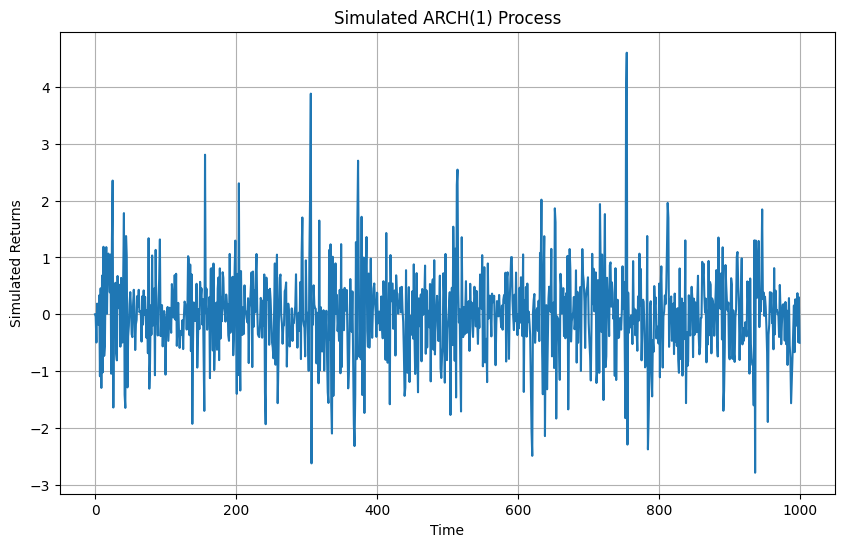

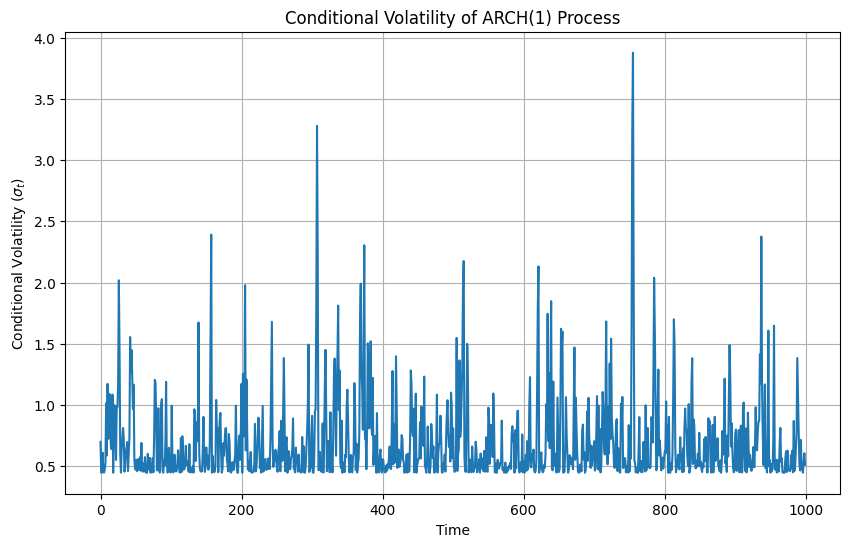

In [32]:
import numpy as np
import matplotlib.pyplot as plt

alpha_0 = 0.2
alpha_1 = 0.7

n = 1000

a_t = np.zeros(n)
sigma_t = np.zeros(n)
sigma_t[0] = 0.7

for t in range(1,n):

    sigma_t[t] = np.sqrt(alpha_0+alpha_1*a_t[t-1]**2)

    a_t[t] = sigma_t[t]*np.random.normal(0,1)

plt.figure(figsize=(10,6))
plt.plot(a_t)
plt.title('Simulated ARCH(1) Process')
plt.xlabel('Time')
plt.ylabel('Simulated Returns')
plt.grid()
plt.figure(figsize=(10,6))
plt.plot(sigma_t)
plt.title('Conditional Volatility of ARCH(1) Process')
plt.xlabel('Time')
plt.ylabel(f'Conditional Volatility ($\sigma_t$)')
plt.grid()
plt.show()


<h2 style="color:red;">GARCH</h2> 

We can generalise an ARCH process by including some moving average components.

We let $a_t = \epsilon_t\sigma_t$

with 

$$
\sigma^2_t = \alpha_0 + \sum_{j=1}^{p}\alpha_{j}a^2_{t-j} + \sum_{j=1}^{q}\beta_{j}\sigma^2_{t-j}
$$

This model allows for more presistent clustering periods. 

Note that $a^2_t$ is an $ARIMA(\max(p,q),q)$ model. This can be shown as follows:

$$
\sigma^2_t = \alpha_0 + \sum_{j=1}^{p}\alpha_{j}a^2_{t-j} + \sum_{j=1}^{q}\theta_{j}\sigma^2_{t-j}
$$

$\sigma^2_t$ represents the error the conditional expectation; hence, we can write $\xi_t = a^2_t-\sigma^2_t$ as the error term. We can then rearrange the previous expression so that the error term explicitly appears:

\begin{align*}
a^2_t =& \xi_t + \alpha_0 + \sum_{j=1}^{\max(p,q)}(\alpha_{j}-\theta_{j})a^2_{t-j} + \sum_{j=1}^{q}\theta_{j}(\sigma^2_{t-j}-a^2_{t-j})  \\
=& \xi_t + \alpha_0 + \sum_{j=1}^{\max(p,q)}(\alpha_{j}-\theta_{j})a^2_{t-j} - \sum_{j=1}^{(\max(p,q))}\theta_{j}\xi_{t-j}\\
=& \xi_t + \alpha_0 + \sum_{j=1}^{\max(p,q)}(\alpha_{j}-\theta_{j})a^2_{t-j} - \sum_{j=1}^{q}\theta_{j}\xi_{t-j}
\end{align*}

where we have added and subtracted $\sum_{j=1}^{(\max(p,q))}\theta_{j}\sigma^2_{t-j}$ in order to substitute $\xi_{t-j}$ and we have defined $\theta_{j}=0$ when $j>q$ and $\alpha_{j}=0$ when $j>p$. The model is known explicitly a $ARMA(\max(p,q),q)$ model with noise term $\xi$.

Below we plot a GARCH(1,1).

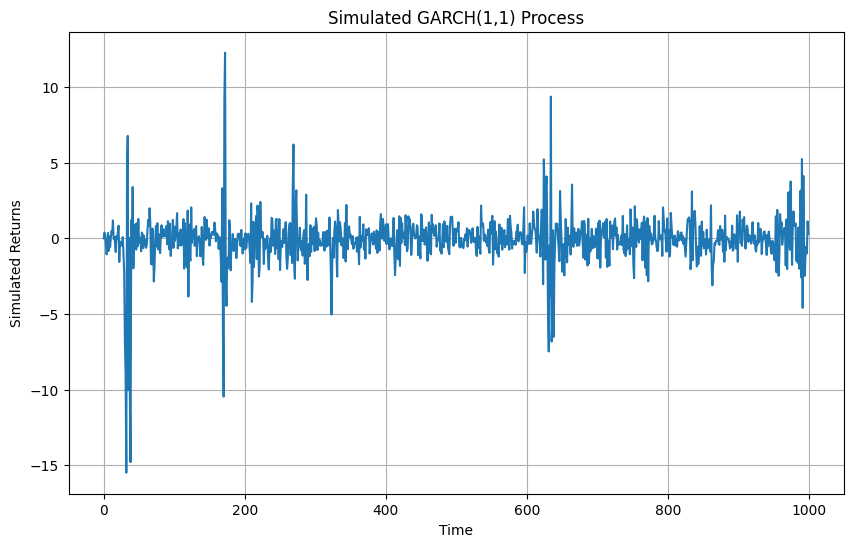

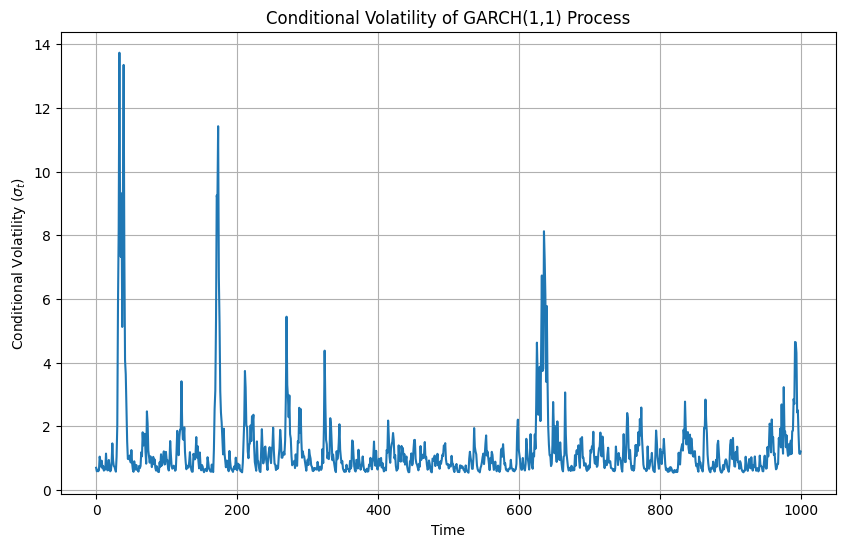

In [38]:
import numpy as np
import matplotlib.pyplot as plt

alpha_0 = 0.2
alpha_1 = 0.7
beta_1 = 0.3

n = 1000

a_t = np.zeros(n)
sigma_t = np.zeros(n)
sigma_t[0] = 0.7

for t in range(1,n):

    sigma_t[t] = np.sqrt(alpha_0+alpha_1*a_t[t-1]**2+beta_1*sigma_t[t-1]**2)

    a_t[t] = sigma_t[t]*np.random.normal(0,1)

plt.figure(figsize=(10,6))
plt.plot(a_t)
plt.title('Simulated GARCH(1,1) Process')
plt.xlabel('Time')
plt.ylabel('Simulated Returns')
plt.grid()
plt.figure(figsize=(10,6))
plt.plot(sigma_t)
plt.title('Conditional Volatility of GARCH(1,1) Process')
plt.xlabel('Time')
plt.ylabel(f'Conditional Volatility ($\sigma_t$)')
plt.grid()
plt.show()
